In [1]:
# Data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

import torch
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance

from sklearn.utils import shuffle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os

# Print first 10 file names as a sample 
count = 0
max_files = 10  # Set the maximum number of files to print

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if count < max_files:
            print(os.path.join(dirname, filename))
            count += 1
        else:
            break

2024-03-07 17:25:57.319820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 17:25:57.319968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 17:25:57.471733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg


# 1. Load Data

In [2]:
# Data directory Colab
#data_dir ='/content/drive/MyDrive/Colab Notebooks/brain-tumor-mri-dataset'

# Data directory Kaggle
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Create labels
labels = []

for sub_folder in os.listdir(os.path.join(data_dir,'Training')):
    labels.append(sub_folder)
print(labels)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [3]:
# Load and combine data from Training and Testing folder
X_train = []
y_train = []
img_size = 224

def read_data(subset):
  for i in labels:
      folderPath = os.path.join(data_dir,subset,i)
      for j in tqdm(os.listdir(folderPath)):
          img = cv2.imread(os.path.join(folderPath,j))
          img = cv2.resize(img,(img_size, img_size))
          X_train.append(img)
          y_train.append(i)

read_data('Training')
read_data('Testing')
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:02<00:00, 102.71it/s]


# 2. Exploratory Data Analysis (EDA)

In [4]:
X_train.shape

(7023, 224, 224, 3)

The shape of the NumPy array containing our dataset is displayed in the output.  7023 224 x 224 pixel photos with three color channels are available.

In [5]:
# Number of samples per class
np.unique(y_train, return_counts=True)

(array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10'),
 array([1621, 1645, 2000, 1757]))

The class balance is shown in the output below. This dataset is very balanced, with each of the four classes making up about 1/4 of the total samples.

### Sample image from each class

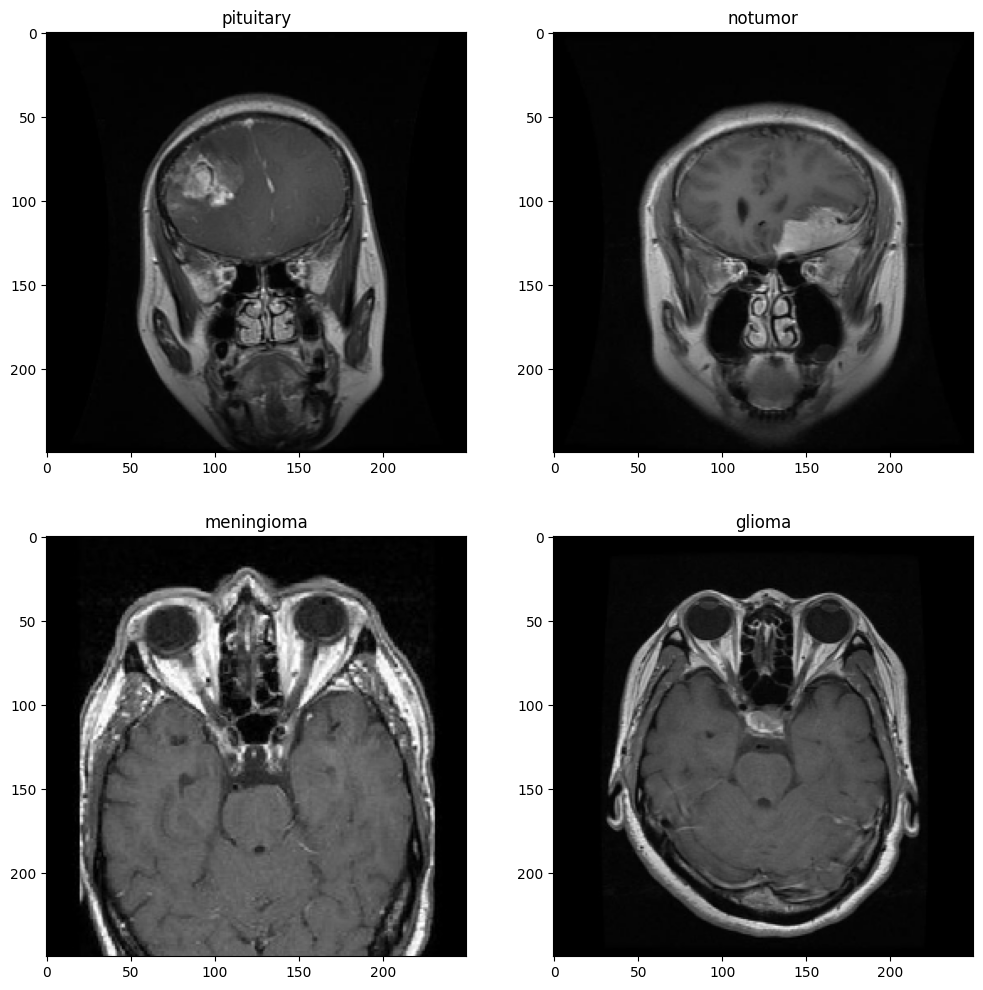

In [6]:
# Plot sample from each class
plt.figure(figsize=(12, 12))

samples_path = ['Training/glioma/Tr-glTr_0000.jpg', 
                'Training/meningioma/Tr-meTr_0000.jpg', 
                'Training/notumor/Tr-noTr_0000.jpg',
                'Training/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(os.path.join(data_dir,samples_path[i]))
    if img is None:
        print('Wrong path')
    else:
      img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(labels[i])

plt.savefig('sample-image-each-class.png', bbox_inches = 'tight')

### Image Visualization With Labels

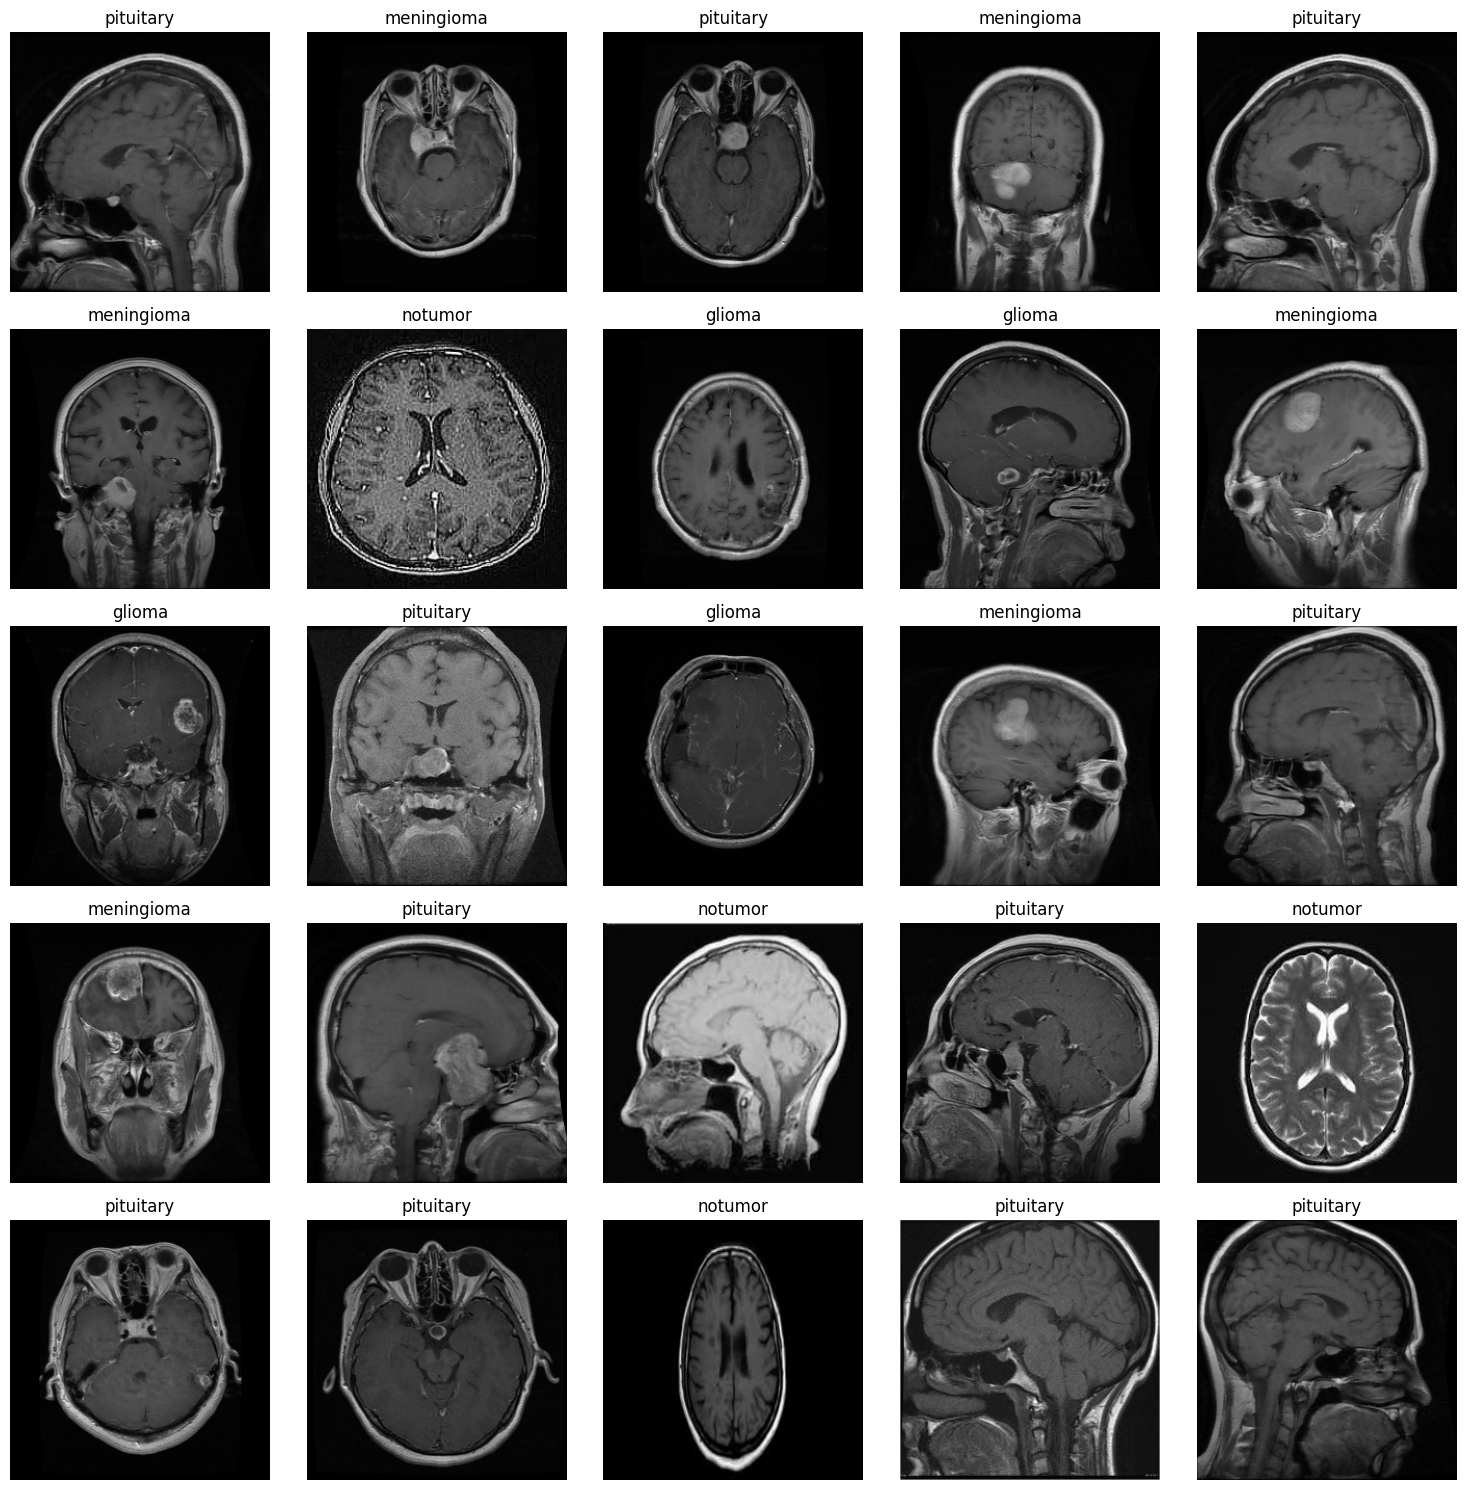

In [7]:
# Get a list of all image paths
image_paths = []
for label in labels:
    class_dir = os.path.join(train_dir, label)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image_paths.append((image_path, label))

# Shuffle the image paths
image_paths = shuffle(image_paths)

# Plot 25 random images with labels
plt.figure(figsize=(15, 15))
for i in range(25):
    image_path, label = image_paths[i]
    img = cv2.imread(image_path)
    img = cv2.resize(img, (250, 250))
    plt.subplot(5, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

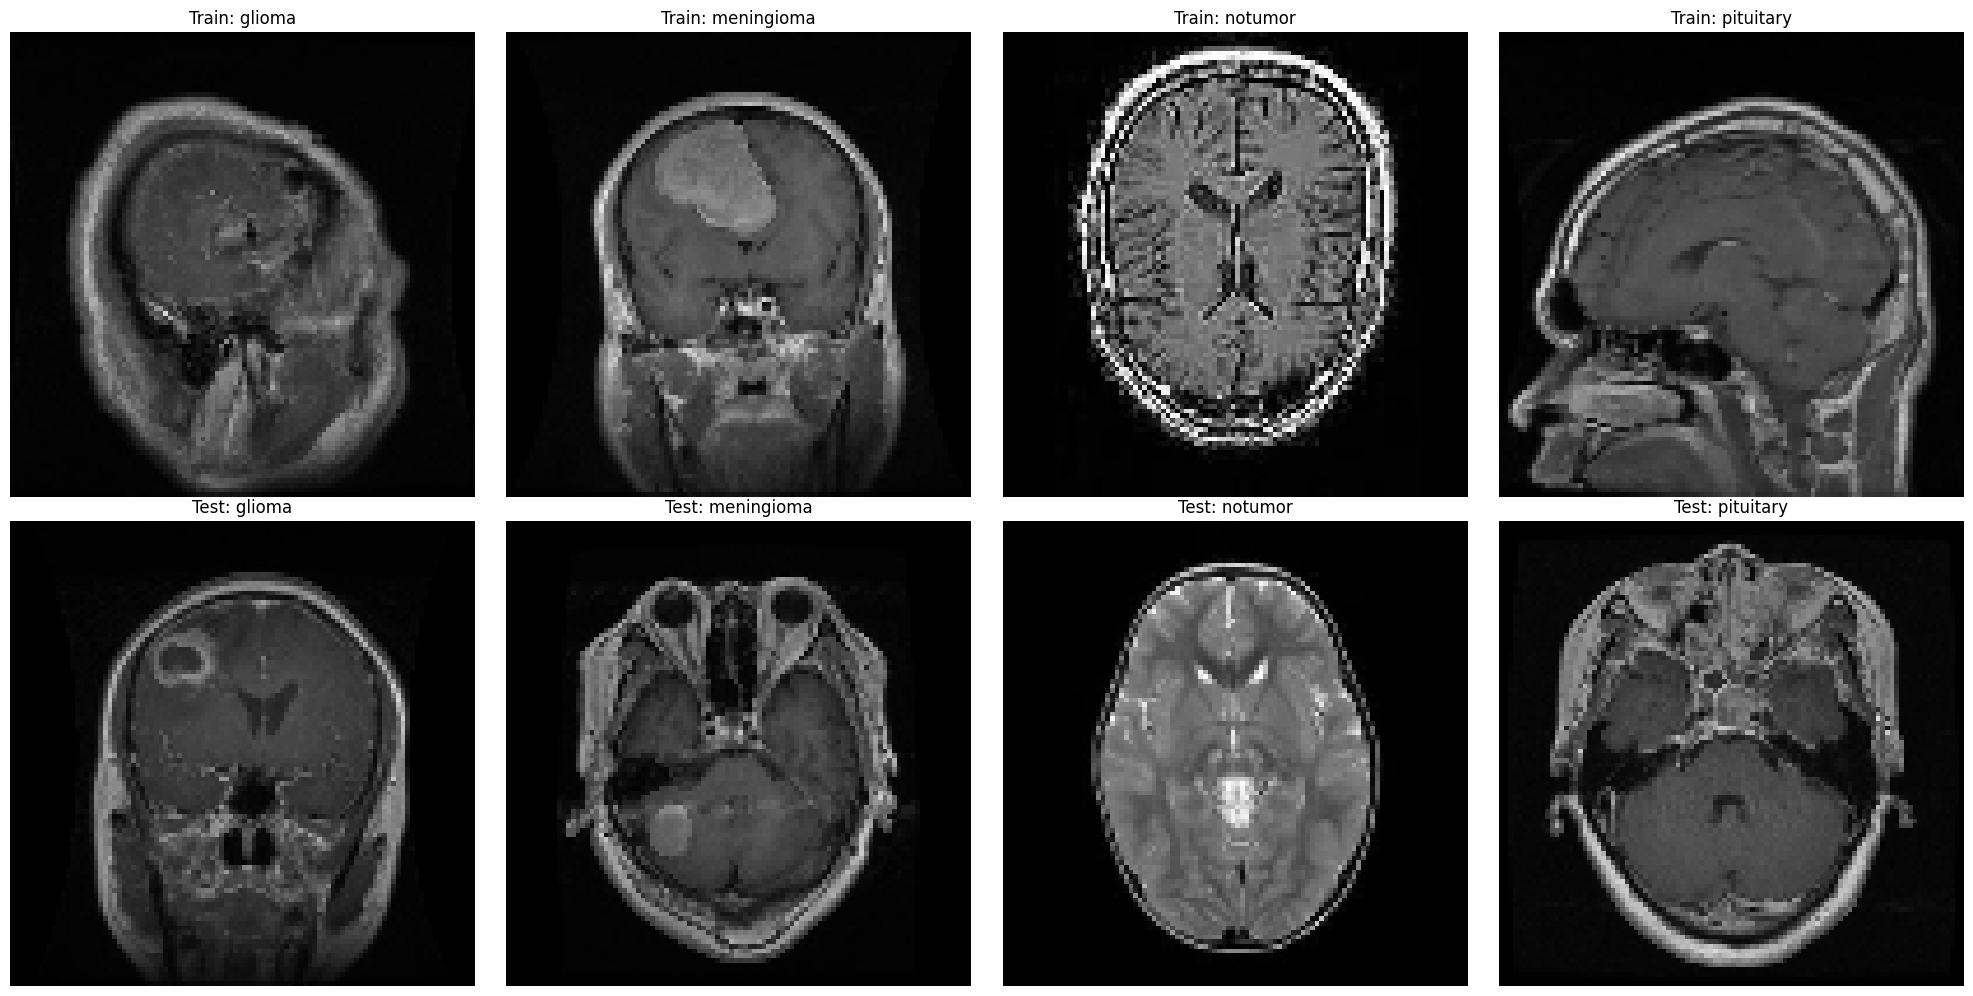

In [8]:
# Define the paths to the images and their corresponding labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(20, 10))
idx = 1

for label in labels:
    # Display images from train set
    train_class_dir = os.path.join(train_dir, label)
    train_images = os.listdir(train_class_dir)
    train_img_path = os.path.join(train_class_dir, train_images[0])  # Selecting the first image for demonstration
    train_img = cv2.imread(train_img_path)
    train_img = cv2.resize(train_img, (100, 100))
    plt.subplot(2, 4, idx)
    plt.imshow(cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Train: {label}')
    plt.axis('off')

    # Display images from test set
    test_class_dir = os.path.join(test_dir, label)
    test_images = os.listdir(test_class_dir)
    test_img_path = os.path.join(test_class_dir, test_images[0])  # Selecting the first image for demonstration
    test_img = cv2.imread(test_img_path)
    test_img = cv2.resize(test_img, (100, 100))
    plt.subplot(2, 4, idx + 4)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Test: {label}')
    plt.axis('off')

    idx += 1

plt.tight_layout()
plt.show()

## Plotting numbers of each class

In [10]:
# Count the number of images in each class for train data
train_counts = {}
for label in labels:
    class_dir = os.path.join(train_dir, label)
    train_counts[label] = len(os.listdir(class_dir))

# Count the number of images in each class for test data
test_counts = {}
for label in labels:
    class_dir = os.path.join(test_dir, label)
    test_counts[label] = len(os.listdir(class_dir))

    # Combine the counts from train and test data
combined_counts = {label: train_counts[label] + test_counts[label] for label in train_counts}
# Iterate over class counts and print the counts as a list
for label, count in combined_counts.items():
    print(f'Folder: {label} contains {count} images')
plt.show()

Folder: glioma contains 1621 images
Folder: meningioma contains 1645 images
Folder: notumor contains 2000 images
Folder: pituitary contains 1757 images


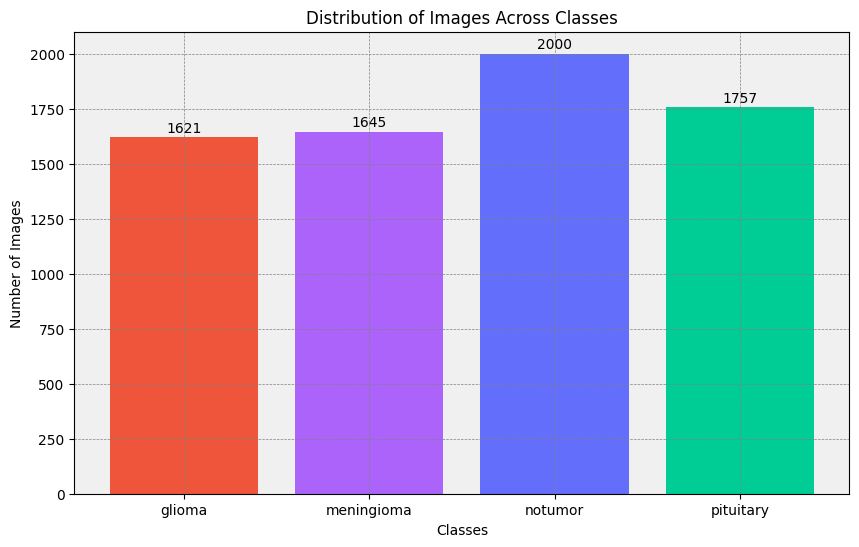

In [11]:
# Combine the counts from train and test data
combined_counts = {label: train_counts[label] + test_counts[label] for label in train_counts}

# Define colors
color_dict = {
    'glioma': '#EF553B',
    'meningioma': '#AB63FA',
    'notumor': '#636EFA',
    'pituitary': '#00CC96'
}

# Map class labels to colors
colors = [color_dict[label] for label in combined_counts.keys()]

plt.figure(figsize=(10, 6))
bars = plt.bar(combined_counts.keys(), combined_counts.values(), color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.gca().set_facecolor('#F0F0F0')  # Light gray background
plt.grid(color='gray', linestyle='--', linewidth=0.5)

for bar, count in zip(bars, combined_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center', va='bottom', color='black')

plt.show()

The dataset is divided into four folders, each representing a different type of brain tumor:

- Glioma: Contains 1621 images.
- Meningioma: Contains 1645 images.
- No Tumor: Contains 2000 images.
- Pituitary: Contains 1757 images.

The distribution of images across the different tumor types is imbalanced, with the "No Tumor" category having the highest number of images (2000) and the "Glioma" category having the lowest (1621). This imbalance could potentially impact the performance of machine learning models trained on this dataset, particularly for tumor types with fewer images.

Further analysis, such as visualizations or statistical tests, could provide more insights into the dataset's characteristics and help in designing appropriate strategies for handling the class imbalance during model training.

In [12]:
filepaths =[]
labels = []
folds = os.listdir(train_dir)

for fold in folds:
    f_path = os.path.join(train_dir , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [13]:
train_df

filepaths      label
0     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
...                                                 ...        ...
5707  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5708  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5709  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5710  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma

[5712 rows x 2 columns]

In [14]:
filepaths =[]
labels = []
folds = os.listdir(test_dir)

for fold in folds:
    f_path = os.path.join(test_dir , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [15]:
test_df

filepaths      label
0     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
...                                                 ...        ...
1306  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1307  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1308  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1309  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma
1310  /kaggle/input/brain-tumor-mri-dataset/Testing/...     glioma

[1311 rows x 2 columns]

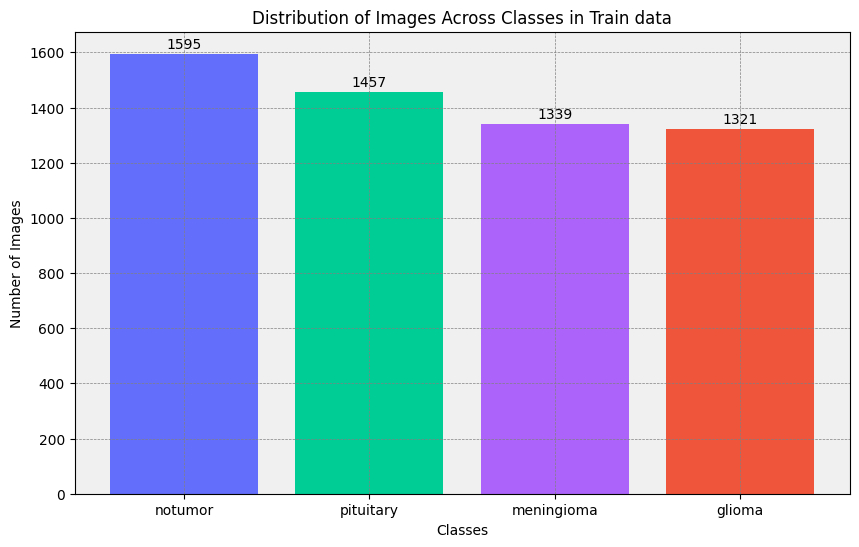

In [16]:
# Count the number of images in each class
class_counts = train_df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=[color_dict[label] for label in class_counts.index])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes in Train data')
plt.gca().set_facecolor('#F0F0F0')  # Light gray background
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Add labels with counts on the bars
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center', va='bottom', color='black')

plt.show()

In [17]:
# Iterate over class counts and print the counts as a list
for label, count in class_counts.items():
    print(f'Folder: {label} contains {count} images')
plt.show()

Folder: notumor contains 1595 images
Folder: pituitary contains 1457 images
Folder: meningioma contains 1339 images
Folder: glioma contains 1321 images


For the training data subset of the brain tumor MRI dataset, we have the following distribution:

- No Tumor: Contains 1595 images.
- Pituitary: Contains 1457 images.
- Meningioma: Contains 1339 images.
- Glioma: Contains 1321 images.

This distribution shows a similar pattern to the overall dataset, with the "No Tumor" category having the highest number of images and the "Glioma" category having the lowest. The class imbalance within the training subset reflects the overall dataset distribution, which is important to consider when training machine learning models to ensure that they are able to effectively learn from all classes.

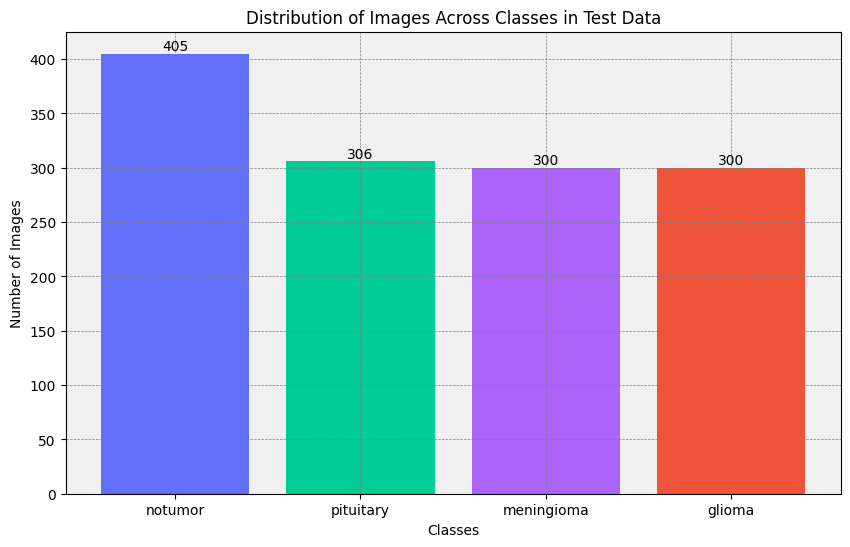

In [18]:
# Count the number of images in each class
class_counts_test = test_df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts_test.values, color=[color_dict[label] for label in class_counts.index])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes in Test Data')
plt.gca().set_facecolor('#F0F0F0')  # Light gray background
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Add labels with counts on the bars
for bar, count in zip(bars, class_counts_test.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom', color='black')

plt.show()

In [19]:
# Iterate over class counts and print the counts as a list
for label, count in class_counts_test.items():
    print(f'Folder: {label} contains {count} images')
plt.show()

Folder: notumor contains 405 images
Folder: meningioma contains 306 images
Folder: pituitary contains 300 images
Folder: glioma contains 300 images


For the test data subset of the brain tumor MRI dataset, we have the following distribution:

- No Tumor: Contains 405 images.
- Meningioma: Contains 306 images.
- Pituitary: Contains 300 images.
- Glioma: Contains 300 images.

Similar to the overall dataset and the training subset, the "No Tumor" category has the highest number of images, and the "Meningioma" category has the fewest. This distribution provides a balanced set of images across the tumor types, which is important for evaluating the performance of machine learning models trained on the training subset.

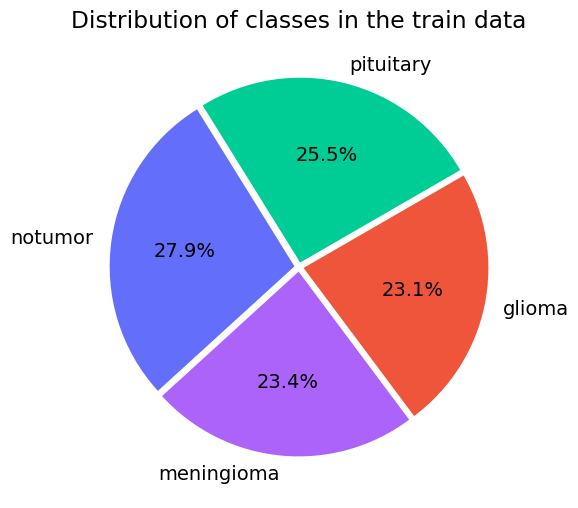

In [20]:
# Calculate class distribution in the training and test data
train_labels = []
for folder in os.listdir(train_dir):
    train_labels.extend([folder] * len(os.listdir(os.path.join(train_dir, folder))))
    
# Create a figure with two subplots
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary', 'notumor', 'meningioma', 'glioma'],
        colors=[color_dict[label] for label in ['pituitary', 'notumor', 'meningioma', 'glioma']],
        autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30)
plt.title('Distribution of classes in the train data')
plt.show()

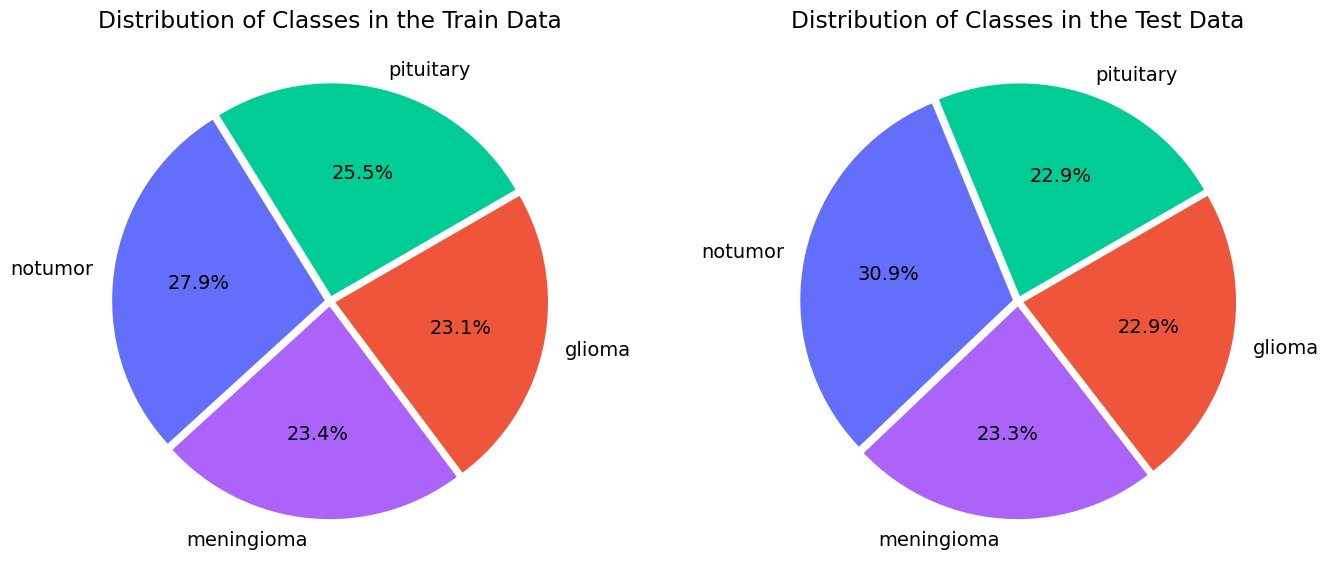

In [21]:
# Calculate class distribution in the training and test data
train_labels = []
for folder in os.listdir(train_dir):
    train_labels.extend([folder] * len(os.listdir(os.path.join(train_dir, folder))))

test_labels = []
for folder in os.listdir(test_dir):
    test_labels.extend([folder] * len(os.listdir(os.path.join(test_dir, folder))))

# Create a figure with two subplots
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})

plt.subplot(1, 2, 1)
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary', 'notumor', 'meningioma', 'glioma'],
        colors=[color_dict[label] for label in ['pituitary', 'notumor', 'meningioma', 'glioma']],
        autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30)
plt.title('Distribution of Classes in the Train Data')

plt.subplot(1, 2, 2)
plt.pie([len([x for x in test_labels if x=='pituitary']),
         len([x for x in test_labels if x=='notumor']),
         len([x for x in test_labels if x=='meningioma']),
         len([x for x in test_labels if x=='glioma'])],
        labels=['pituitary', 'notumor', 'meningioma', 'glioma'],
        colors=[color_dict[label] for label in ['pituitary', 'notumor', 'meningioma', 'glioma']],
        autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30)
plt.title('Distribution of Classes in the Test Data')

plt.tight_layout()
plt.show()

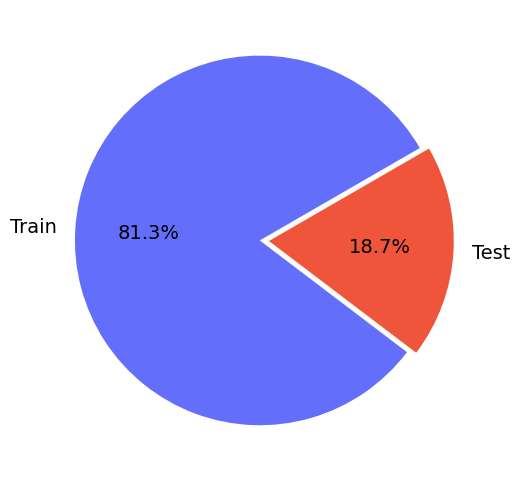

In [22]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
plt.figure(figsize=(14,6))
colors = ['#636EFA', '#EF553B']  # Violet and Blue colors
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05, 0),
        startangle=30)
plt.show()

The numbers (81.3% for training and 18.7% for testing) represent the proportion of the dataset allocated for training and testing a machine learning model, respectively.

- Training (81.3%): This indicates that 81.3% of the dataset is used to train the model. A larger training set typically allows the model to learn more effectively, as it has more data to generalize patterns from.

- Testing (18.7%): This indicates that 18.7% of the dataset is reserved for testing the trained model's performance. The test set is crucial for evaluating how well the model generalizes to new, unseen data. A smaller test set is common to ensure a sufficient amount of data is available for training.

This split suggests a relatively large training set, which can be beneficial for training complex models or dealing with high-dimensional data, while still retaining a reasonable amount of data for testing the model's performance.

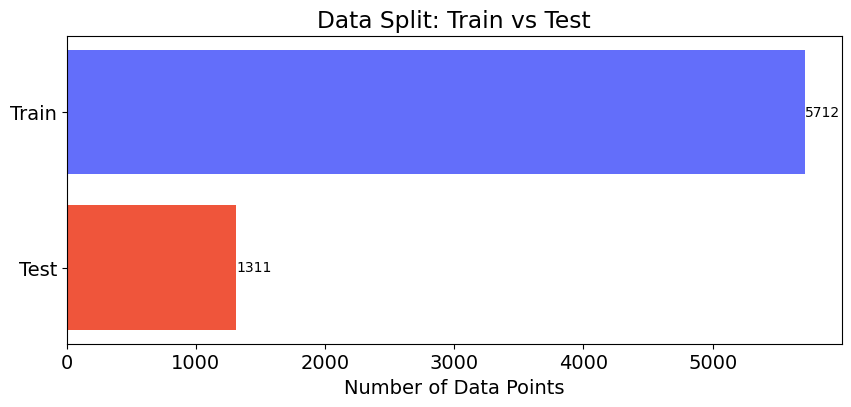

In [23]:
# Data
labels = ['Train', 'Test']
data = [len(train_labels), len(test_labels)]
colors = ['#636EFA', '#EF553B']

# Create a horizontal bar chart
plt.figure(figsize=(10, 4))
bars = plt.barh(labels, data, color=colors)

# Add labels and values
for bar, d in zip(bars, data):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, str(d), va='center', fontsize=10, color='black')

# Set the title and adjust the layout
plt.title('Data Split: Train vs Test')
plt.xlabel('Number of Data Points')
plt.gca().invert_yaxis()  # Invert the y-axis to have "Train" on top
plt.show()

Number of images in training:  5712
Number of images in testing:  1311


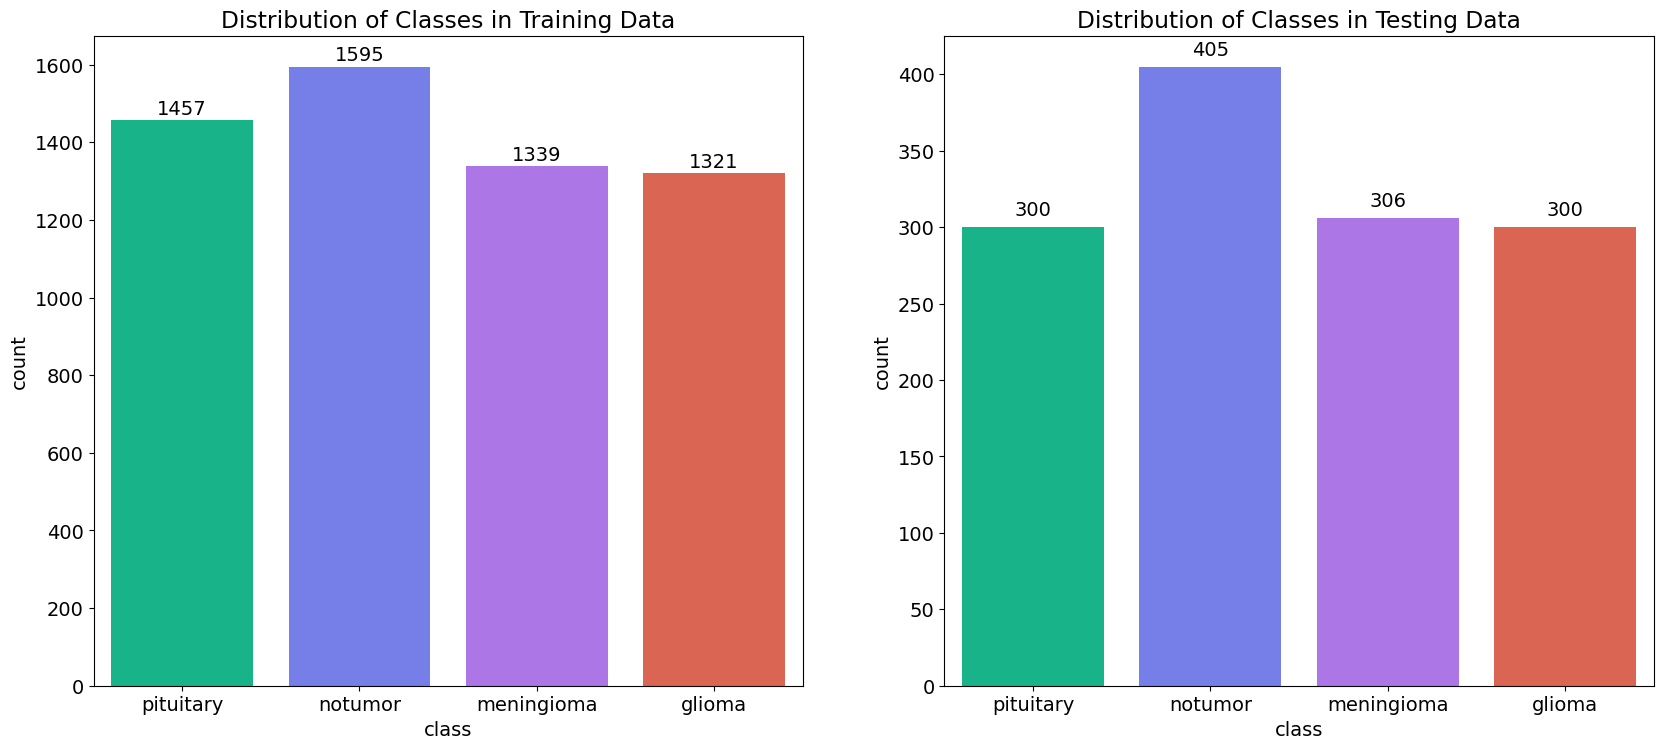

In [24]:
data_dir = '../input/brain-tumor-mri-dataset'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(train_dir):
    quantity_tr[folder] = len(os.listdir(os.path.join(train_dir, folder)))

for folder in os.listdir(test_dir):
    quantity_te[folder] = len(os.listdir(os.path.join(test_dir, folder)))

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(train_dir):
    quantity_tr[folder] = len(os.listdir(os.path.join(train_dir, folder)))

for folder in os.listdir(test_dir):
    quantity_te[folder] = len(os.listdir(os.path.join(test_dir, folder)))

quantity_train = pd.DataFrame(list(quantity_tr.items()), columns=['class', 'count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), columns=['class', 'count'])

color_dict = {
    'glioma': '#EF553B',
    'meningioma': '#AB63FA',
    'notumor': '#636EFA',
    'pituitary': '#00CC96'
}

figure, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x='class', y='count', data=quantity_train, ax=ax[0], palette=color_dict)
sns.barplot(x='class', y='count', data=quantity_test, ax=ax[1], palette=color_dict)

# Adding labels on the bars
for i, bar in enumerate(ax[0].patches):
    height = bar.get_height()
    ax[0].text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        quantity_train['count'][i],
        ha='center',
        va='bottom'
    )

for i, bar in enumerate(ax[1].patches):
    height = bar.get_height()
    ax[1].text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        quantity_test['count'][i],
        ha='center',
        va='bottom'
    )

# Adjusting plot margins
plt.subplots_adjust(left=0.2, right=1.5, top=1.5, bottom=0.2)

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))

# Naming the charts
ax[0].set_title('Distribution of Classes in Training Data')
ax[1].set_title('Distribution of Classes in Testing Data')

plt.show()

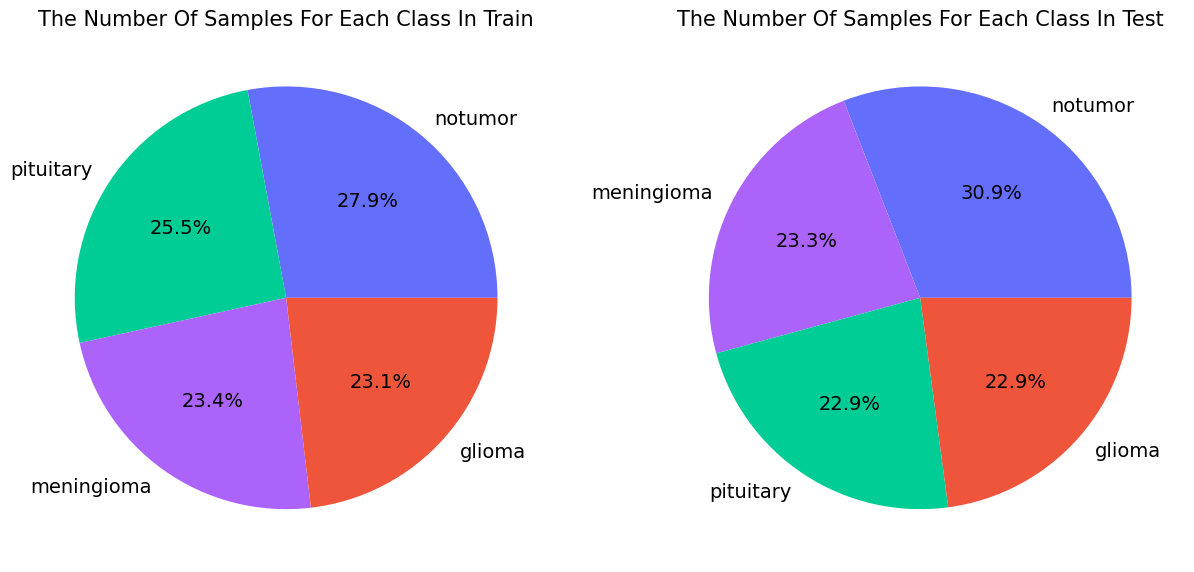

In [25]:
# Create a figure with two subplots
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.pie(train_df.label.value_counts(), labels=train_df.label.value_counts().index, autopct='%1.1f%%', colors=[color_dict[label] for label in train_df.label.value_counts().index])
plt.title("The Number Of Samples For Each Class In Train", fontsize=15)

plt.subplot(1, 2, 2)
plt.pie(test_df.label.value_counts(), labels=test_df.label.value_counts().index, autopct='%1.1f%%', colors=[color_dict[label] for label in test_df.label.value_counts().index])
plt.title("The Number Of Samples For Each Class In Test", fontsize=15)

plt.show()

In [27]:
# Function to load an image
def load_image(img_path):
    return tf.keras.preprocessing.image.load_img(img_path)

# Function to load an image as a numpy array
def _load(img_path):
    return tf.keras.preprocessing.image.img_to_array(load_image(img_path))

# Define the paths to the images and their corresponding labels
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')
labels = os.listdir(train_dir)

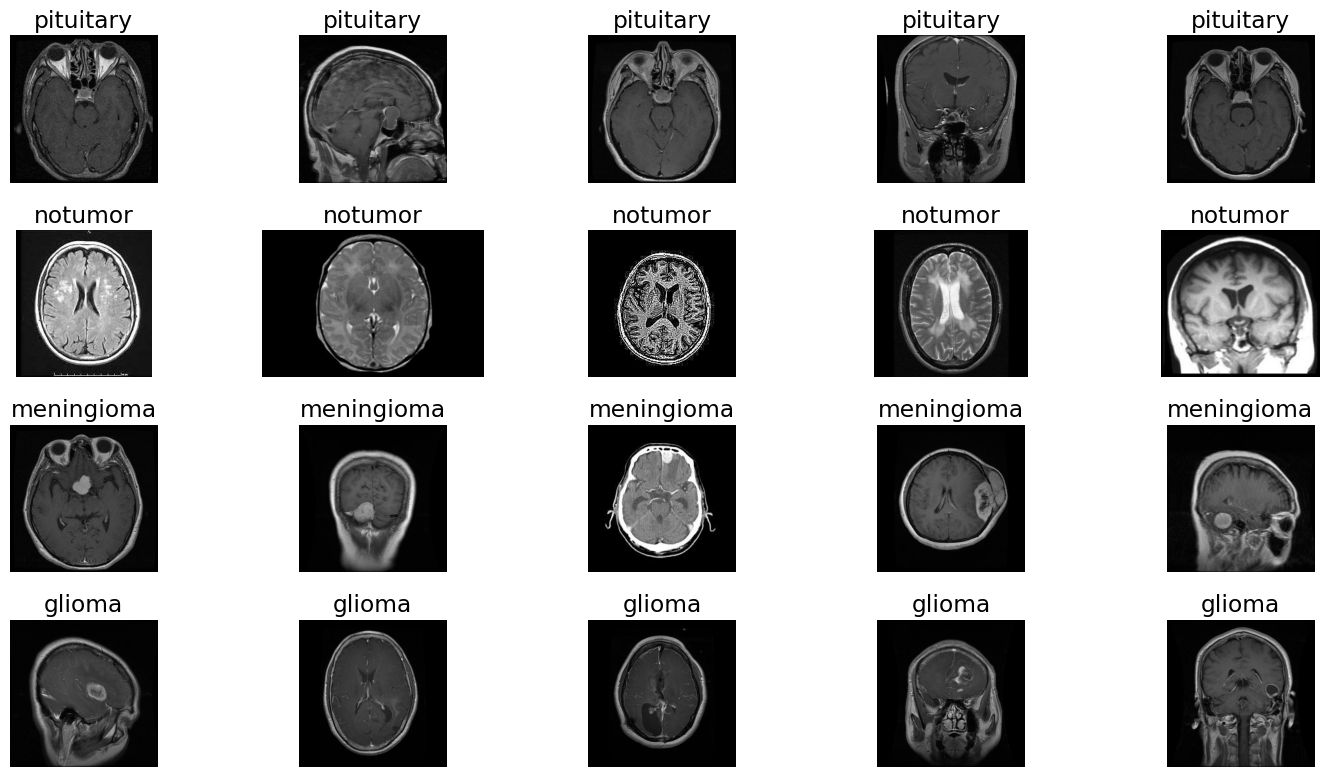

In [28]:
# Create labels
labels = os.listdir(os.path.join(data_dir, 'Training'))

# Function to load and preprocess image
def load_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Function to display multiple samples
def display_samples(data_dir, labels, sample_count=5, figsize=(15, 8)):
    fig, axs = plt.subplots(len(labels), sample_count, figsize=figsize)
    for i, label in enumerate(labels):
        class_dir = os.path.join(data_dir, 'Training', label)
        sample_files = random.sample(os.listdir(class_dir), sample_count)
        for j, file_name in enumerate(sample_files):
            img_path = os.path.join(class_dir, file_name)
            img = load_image(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(label)
    plt.tight_layout()
    plt.show()

# Display sample images
display_samples(data_dir, labels)

In [29]:
# Function to load an image
def load_image(img_path):
    with Image.open(img_path) as img:
        return img.convert('L')  # Convert to grayscale

# Calculate image statistics
image_stats = []
for label in labels:
    class_dir = os.path.join(train_dir, label)
    for file_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, file_name)
        img = load_image(img_path)
        image_stats.append({
            'label': label,
            'width': img.size[0],
            'height': img.size[1],
            'mean_intensity': np.mean(img),
            'std_intensity': np.std(img)
        })

# Create a DataFrame for image statistics
image_stats_df = pd.DataFrame(image_stats)

# Display basic image statistics
print('Image Statistics:')
print(image_stats_df.groupby('label').agg({
    'width': ['mean', 'std'],
    'height': ['mean', 'std'],
    'mean_intensity': ['mean', 'std'],
    'std_intensity': ['mean', 'std']
}))

Image Statistics:
                 width                  height             mean_intensity  \
                  mean         std        mean         std           mean   
label                                                                       
glioma      512.000000    0.000000  512.000000    0.000000      32.711430   
meningioma  493.393577   75.804275  495.233757   72.415302      43.482108   
notumor     313.947962  167.319780  320.733542  156.342905      60.723721   
pituitary   508.974605   49.185817  508.952642   48.981983      49.267893   

                      std_intensity             
                  std          mean        std  
label                                           
glioma       8.564805     38.325023   5.802540  
meningioma  14.308397     46.733826   7.888956  
notumor     21.244181     60.561156  16.060878  
pituitary    8.223707     41.403495   4.777836  



These statistics provide insights into the characteristics of the images in the dataset for different types of brain tumors:

- Width and Height: The mean width and height of the images are provided for each tumor type. For example, glioma images have a mean width and height of 512 pixels, meningioma images have a mean width of approximately 493 pixels and a mean height of approximately 495 pixels, notumor images have a mean width of approximately 314 pixels and a mean height of approximately 321 pixels, and pituitary images have a mean width of approximately 509 pixels and a mean height of approximately 509 pixels.

- Mean Intensity: This represents the mean pixel intensity across all images for each tumor type. For instance, glioma images have a mean intensity of approximately 32.71, meningioma images have a mean intensity of approximately 43.48, notumor images have a mean intensity of approximately 60.72, and pituitary images have a mean intensity of approximately 49.27.

- Standard Deviation of Intensity: This indicates the variability of pixel intensities within the images for each tumor type. For example, glioma images have a standard deviation of intensity of approximately 8.56, meningioma images have a standard deviation of intensity of approximately 14.31, notumor images have a standard deviation of intensity of approximately 21.24, and pituitary images have a standard deviation of intensity of approximately 8.22.

These statistics are useful for understanding the distribution and characteristics of the images in the dataset, which is important for preprocessing and analysis tasks, such as normalization, filtering, or feature extraction.

Based on the image statistics, here are some suggestions for preprocessing and analysis:

- Standardize Image Sizes: Since the images vary in size, it might be beneficial to resize them to a consistent size (e.g., 256x256 or 512x512 pixels) to ensure uniformity across the dataset.

- Normalize Pixel Intensities: Normalizing pixel intensities can help in reducing the impact of variations in mean intensity values across different tumor types. This can be done by scaling the pixel values to a range of [0, 1] or [-1, 1].

- Enhance Contrast: Adjusting the contrast of the images based on their mean intensity values can help in improving the visibility of features, especially in images with lower mean intensities like glioma.

- Noise Reduction: Given the variability in intensity within each tumor class, applying noise reduction techniques such as Gaussian blur or median filtering can help in improving image quality and reducing the impact of outliers.

- Feature Extraction: Consider extracting meaningful features from the images, such as texture features or shape descriptors, to capture important characteristics for tumor classification.

- Class Balancing: Since the dataset is imbalanced, with the "No Tumor" class having the highest number of images, consider using techniques such as oversampling, undersampling, or generating synthetic samples to balance the classes, which can improve the model's performance.

- Data Augmentation: Augmenting the dataset by applying transformations such as rotation, flipping, and scaling can help in increasing the diversity of the dataset and improving the model's ability to generalize.

- Model Selection: Based on the characteristics of the dataset, consider using deep learning models such as convolutional neural networks (CNNs), which are well-suited for image classification tasks and can automatically learn relevant features from the images.

These techniques can help in preprocessing the dataset and designing a robust machine learning pipeline for analyzing brain tumor MRI images.

In [36]:
# Check the column names in your DataFrame
print(data_df.columns)

Index(['image_path', 'label'], dtype='object')


# Data Augmentation

Found 5712 validated image filenames belonging to 4 classes.


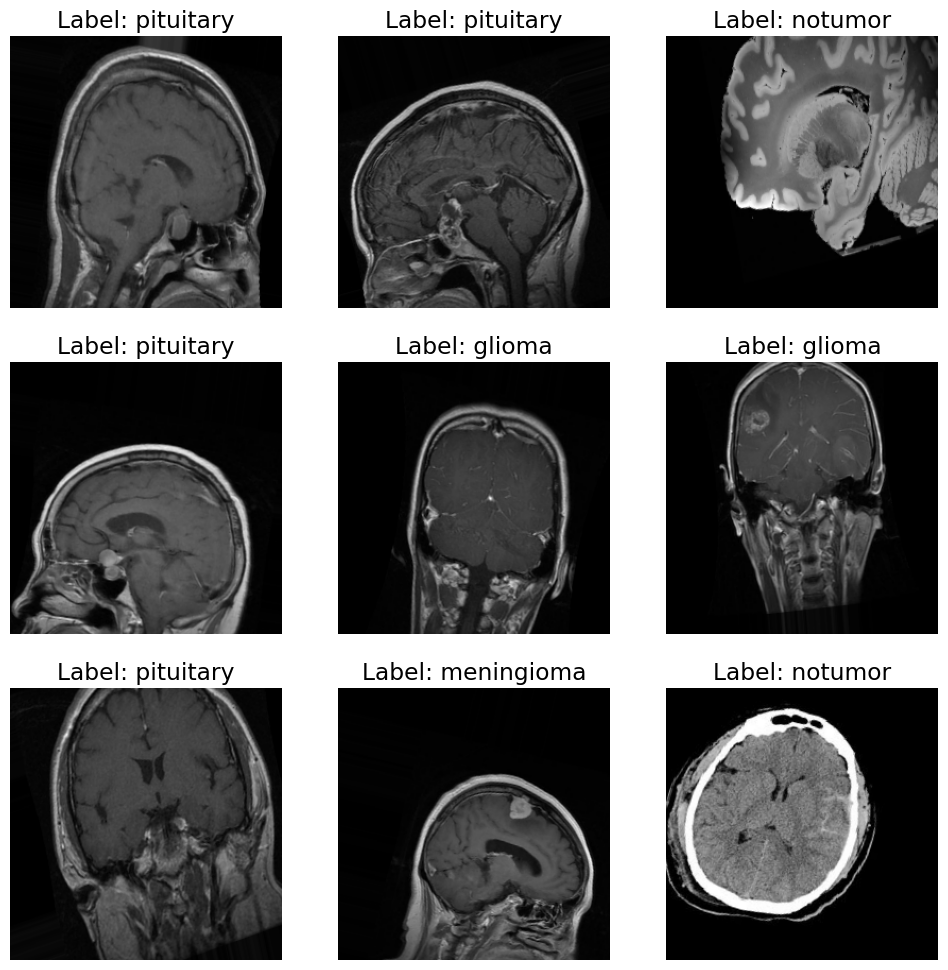

In [39]:
# Data directory Kaggle
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Get the list of all image paths in the training directory
train_image_paths = []
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        label = folder
        for file_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file_name)
            if os.path.isfile(image_path):
                train_image_paths.append((image_path, label))

# Create a DataFrame from the list of image paths
data_df = pd.DataFrame(train_image_paths, columns=['image_path', 'label'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Visualize augmented images
augmented_images = datagen.flow_from_dataframe(
    dataframe=data_df,  # Use the data_df DataFrame here
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=9,
    class_mode='categorical')

label_map = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}  # Define a mapping from numeric labels to label names

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = augmented_images.next()
    image = batch[0][0].astype('uint8')
    label_index = np.argmax(batch[1][0])  # Get the index of the predicted label
    label_name = label_map[label_index]   # Map the index to the label name
    plt.imshow(image)
    plt.title(f'Label: {label_name}')
    plt.axis('off')
plt.show()

# Preprocess all images in the dataset

In [40]:
# Function to preprocess an image
def preprocess_image(img_path, target_size=(256, 256), grayscale=True):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return None
    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    return img

# Preprocess all images in the dataset
preprocessed_images = []
for folder in os.listdir(os.path.join(data_dir, 'Training')):
    for file in os.listdir(os.path.join(data_dir, 'Training', folder)):
        img_path = os.path.join(data_dir, 'Training', folder, file)
        preprocessed_img = preprocess_image(img_path, grayscale=True)
        if preprocessed_img is not None:
            preprocessed_images.append(preprocessed_img)

# Convert the list of images to a numpy array
preprocessed_images = np.array(preprocessed_images)
print("Preprocessed images shape:", preprocessed_images.shape)

Preprocessed images shape: (5712, 256, 256)


In [41]:
from sklearn.model_selection import train_test_split

data_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

labels = []

for sub_folder in os.listdir(os.path.join(data_dir,'Training')):
    labels.append(sub_folder)

X_data = []
y_data = []
img_size = 224
num_images = 500

def read_data(subset):
    for i in labels:
        folderPath = os.path.join(data_dir, subset, i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath, j))
            img = cv2.resize(img, (img_size, img_size))
            X_data.append(img)
            y_data.append(i)

read_data('Training')
read_data('Testing')

X_data = np.array(X_data)
y_data = np.array(y_data)

# Normalize pixel values
X_data = X_data.astype('float32') / 255.0

# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_data_encoded = label_encoder.fit_transform(y_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_encoded, test_size=0.2, random_state=42)

100%|██████████| 300/300 [00:00<00:00, 301.93it/s]


In [ ]:
import torch
import torchvision.models as models

# Load pre-trained ResNet-18
#resnet18 = models.resnet18(pretrained=True)

#Define the models:
from tensorflow.keras.applications import InceptionV3, NASNetMobile, ResNet50, VGG16, DenseNet121

models = {
   # "GoogleNet": InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3)),
   # "MnasNet": NASNetMobile(weights=None, include_top=False, input_shape=(224, 224, 3)),
    "Resnet50": ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3)),
   # "Resnet18": resnet18,  # Use the loaded ResNet-18 model, the input shape for the images is 224x224 pixels with 3 channels (RGB)
    "VGG16": VGG16(weights=None, include_top=False, input_shape=(224, 224, 3)),
   # "Alexnet": DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
}

In [ ]:
#Compile and train the models:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Add custom layers for classification
    model = Sequential([
        model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    results[name] = accuracy

# Print the results
for name, accuracy in results.items():
    print(f"{name}: {accuracy}")

In [ ]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    # Add custom layers for classification
    new_model = Sequential([
        model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model
    history = new_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
    end_time = time.time()
    # Evaluate the model
    loss, test_accuracy = new_model.evaluate(X_test, y_test)
    results[name] = {
        'Training Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Test Accuracy': test_accuracy,
        'Training Time': end_time - start_time
    }

# Print the results
for name, metrics in results.items():
    print(f"{name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value}")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

learning_rate_scheduler = LearningRateScheduler(lr_schedule)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[learning_rate_scheduler])

In [ ]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    # Add custom layers for classification
    new_model = Sequential([
        model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # Train the model
    history = new_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    end_time = time.time()
    # Evaluate the model
    loss, test_accuracy = new_model.evaluate(X_test, y_test)
    results[name] = {
        'Training Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Test Accuracy': test_accuracy,
        'Training Time': end_time - start_time
    }

# Print the results
for name, metrics in results.items():
    print(f"{name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value}")